In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 11.1 MB/s eta 0:00:00a 0:00:01


In [3]:
from fastai.vision.all import *
from fastbook import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
matplotlib.rc('image',cmap="Greys")

In [5]:
top_edge=tensor([[-1,-1,-1],
                [0,0,0],
                [1,1,1]]).float()

In [6]:
top_edge

tensor([[-1., -1., -1.],
        [ 0.,  0.,  0.],
        [ 1.,  1.,  1.]])

In [7]:
path=untar_data(URLs.MNIST_SAMPLE)

In [8]:
Path.BASE_PATH=path

<Axes: >

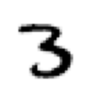

In [9]:
im3=Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [10]:
im3_t=tensor(im3)

In [11]:
(im3_t[0:3,0:3]*top_edge).sum()

tensor(0.)

In [12]:
df=pd.DataFrame(im3_t[:10,:20])


In [13]:
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [14]:
print(im3_t[4:7,6:9])
(im3_t[4:7,6:9]*top_edge).sum()

tensor([[  0,   0,   0],
        [142, 155, 246],
        [254, 254, 254]], dtype=torch.uint8)


tensor(762.)

In [15]:
print(im3_t[7:10,17:20])
print((im3_t[7:10,17:20]*top_edge).sum())

tensor([[254,  75,   0],
        [254, 153,   0],
        [247,  53,   0]], dtype=torch.uint8)
tensor(-29.)


In [16]:
def apply_kernel(row,col,kernel):
    return (im3_t[row-1:row+2,col-1:col+2]*kernel).sum()
    

In [17]:
apply_kernel(5,6,top_edge)

tensor(762.)

In [18]:
[[(i,j) for j in range(1,5)] for i in range(1,5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

In [19]:
rng = range(1,27)
top_edge3=tensor([[apply_kernel(i,j,top_edge) for j in rng] for i in rng])

<Axes: >

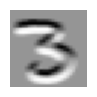

In [20]:
show_image(top_edge3)

In [21]:
left_edge=tensor([[-1,0,1],
                  [-1,0,1],
                  [-1,0,1]]).float()

<Axes: >

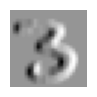

In [22]:
left_edge3=tensor([[apply_kernel(i,j,left_edge) for j in rng] for i in rng])
show_image(left_edge3)

In [23]:
left_edge_a=tensor([[-1,1,0],
                  [-1,1,0],
                  [-1,1,0]]).float()

<Axes: >

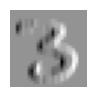

In [24]:
left_edge3_a=tensor([[apply_kernel(i,j,left_edge_a) for j in rng] for i in rng])
show_image(left_edge3_a)

In [25]:
diag1_edge=tensor([[0,-1,1],
             [-1,1,0],
             [ 1,0,0]]).float()

In [26]:
diag2_edge=tensor([1,-1,0],
            [0, 1,-1],
            [0, 0,-1]).float()

In [27]:
edge_kernels=torch.stack([left_edge,top_edge,diag1_edge,diag2_edge])


In [28]:
edge_kernels.shape


torch.Size([4, 3, 3])

In [29]:
mnist=DataBlock((ImageBlock(cls=PILImageBW) ,CategoryBlock),
               get_items=get_image_files,
               splitter=GrandparentSplitter(),
               get_y=parent_label)
dls=mnist.dataloaders(path)


In [30]:
xb,yb=first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [31]:
xb,yb=to_cpu(xb),to_cpu(yb)

In [32]:
edge_kernels.shape,edge_kernels.unsqueeze(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [33]:
edge_kernels=edge_kernels.unsqueeze(1)

In [34]:
batch_features=F.conv2d(xb,edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

<Axes: >

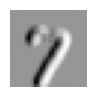

In [35]:
show_image(batch_features[45,0])

In [36]:
broken_cnn=sequential(
nn.Conv2d(1,30,kernel_size=3,padding=1),
nn.ReLU(),
nn.Conv2d(30,1,kernel_size=3,padding=1)
)

In [37]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [38]:
def  conv(ni,nf,ks=3,act=True):
    res = nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)
    if act:
        res=nn.Sequential(res,nn.ReLU())
    return res

In [39]:
simple_cnn = sequential(
conv(1,4),
conv(4,8),
conv(8,16),
conv(16,32),
conv(32,2,act=False),
Flatten(),
)

In [40]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [41]:
learn=Learner(dls,simple_cnn,loss_func=F.cross_entropy,metrics=accuracy)

In [42]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [43]:
learn.fit_one_cycle(2,0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.075226,0.046880,0.987242,00:09
1,0.029266,0.030713,0.991659,00:09


In [44]:
m=learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [45]:
m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [46]:
m[0].bias.shape

torch.Size([4])

In [47]:
im=image2tensor(Image.open(image_bear()))
im.shape

torch.Size([3, 1000, 846])

<Axes: >

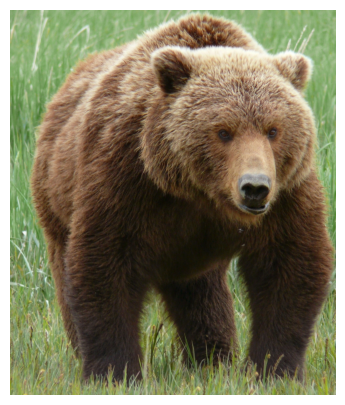

In [48]:
show_image(im)

In [49]:
im.shape

torch.Size([3, 1000, 846])

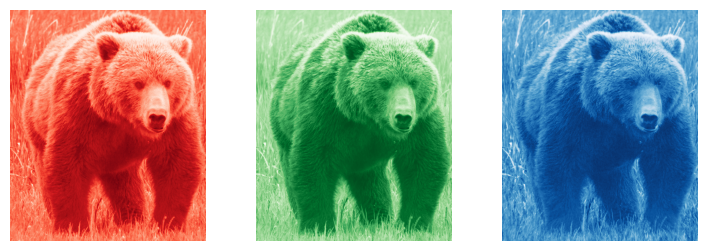

In [50]:
_,axs=subplots(1,3)
for bear,ax,color in zip(im,axs,('Reds','Greens','Blues')):
    show_image(255-bear,ax=ax,cmap=color)
    

<Axes: >

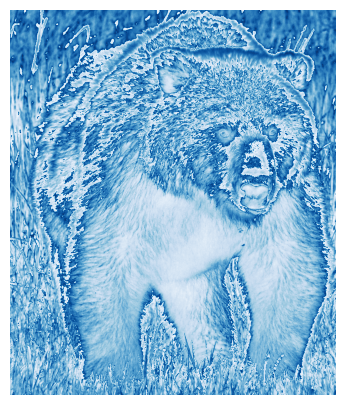

In [51]:
a=list(zip(im,axs,('Reds','Greens','Blues')))
show_image(a[2][0]  + a[0][0] + a[1][0], cmap='Blues')

In [52]:
path=untar_data(URLs.MNIST)

In [53]:
Path.BASE_PATH=path

In [54]:
path.ls()

(#2) [Path('testing'),Path('training')]

In [55]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW),CategoryBlock),
                    get_items=get_image_files,
                    get_y=parent_label,
                    splitter=GrandparentSplitter('training','testing'),
                    batch_tfms=Normalize()).dataloaders(path,bs=bs)

In [56]:
dls=get_dls()

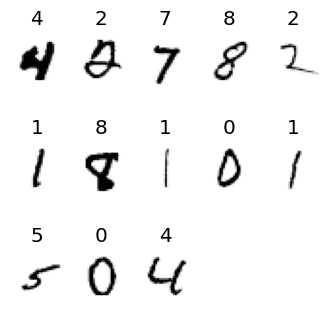

In [57]:
dls.show_batch(max_n=13,figsize=(4,4))

In [58]:
def conv(ni,nf,stride=2,ks=3,act=True):
    res= nn.Conv2d(ni,nf,stride=stride,kernel_size=ks,padding=ks//2)
    if act: res=nn.Sequential(res,nn.ReLU())
    return res 

In [59]:
def sample_cnn():
    return sequential(
    conv(1,8,ks=5),
    conv(8,16),
    conv(16,32),
    conv(32,64),
    conv(64,10,act=False),
    Flatten()
    )

In [60]:
from fastai.callback.hook import *

In [61]:
def fit(epochs=1):
    learn=Learner(dls,sample_cnn(),loss_func=F.cross_entropy,metrics=accuracy,
                  cbs=ActivationStats(with_hist=True))
    learn.fit(epochs,0.56)
    return learn

In [69]:
learn.model.training = True

In [70]:
learn=fit()

/opt/conda/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.337656,2.336787,0.102800,01:05


In [65]:
learn.model[0]

Sequential(
  (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
)

In [63]:
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 8 x 14 x 14    
Conv2d                                    208        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 7 x 7     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 4 x 4     
Conv2d                                    4640       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 2 x 2     
Conv2d                                    18496      True      
ReLU                                          

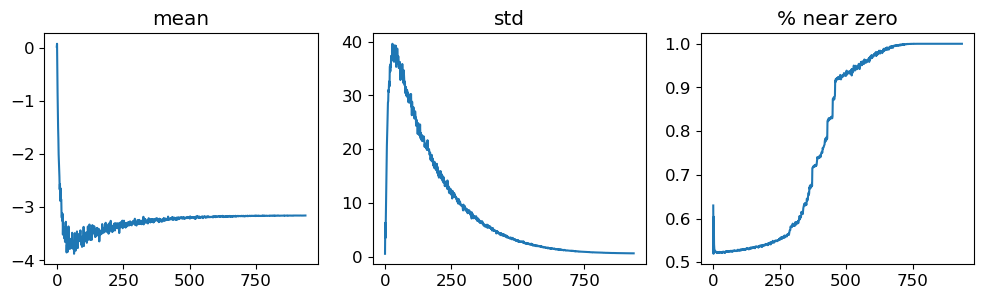

In [71]:

learn.activation_stats.plot_layer_stats(0)

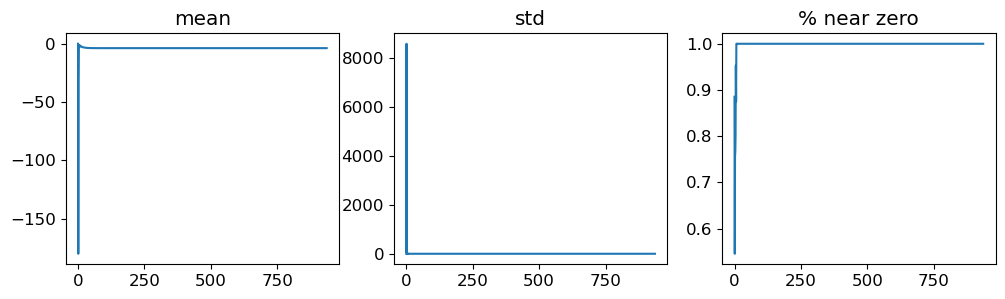

In [78]:
learn.activation_stats.plot_layer_stats(-2)

In [82]:
dls=get_dls(512)

In [86]:
learn=fit()

/opt/conda/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,169.556854,2.302938,0.101000,00:49


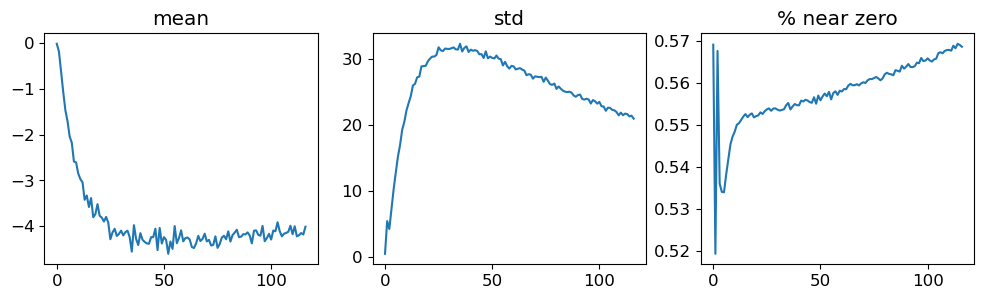

In [87]:
learn.activation_stats.plot_layer_stats(0)

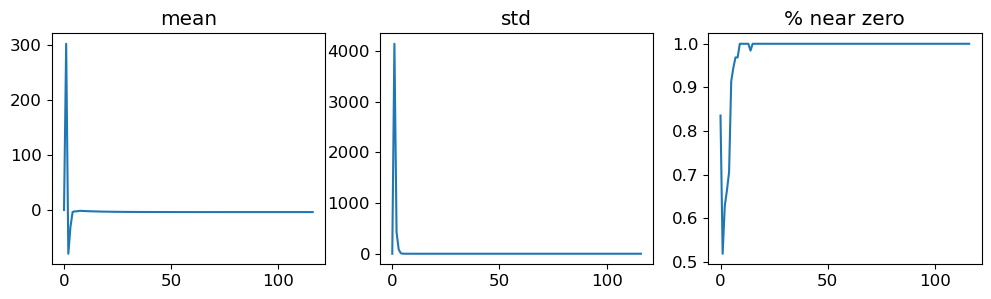

In [88]:
learn.activation_stats.plot_layer_stats(-2)

In [91]:
def fit(epochs=1,lr=0.06):
    learn=Learner(dls,sample_cnn(),loss_func=F.cross_entropy,
                 metrics=accuracy,cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs,lr)
    return learn

In [92]:
learn=fit()

/opt/conda/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.202782,0.071419,0.978400,00:49


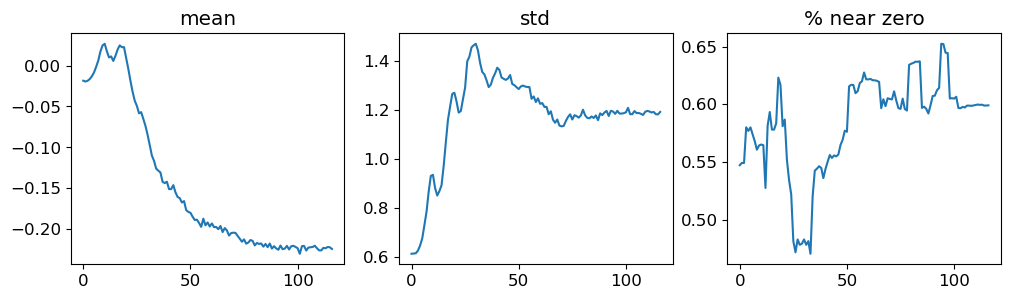

In [93]:
learn.activation_stats.plot_layer_stats(0)

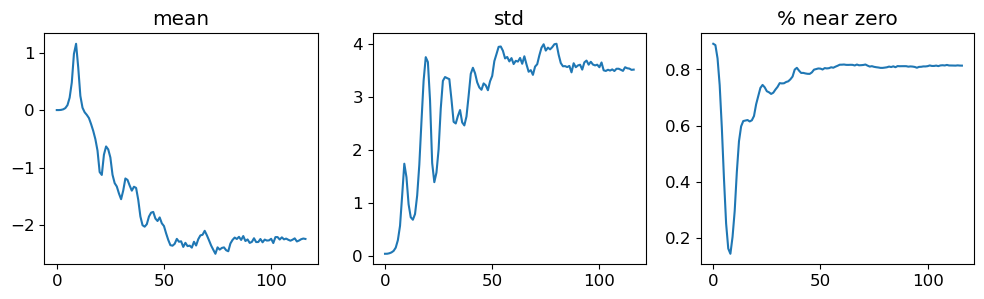

In [95]:
learn.activation_stats.plot_layer_stats(-2)

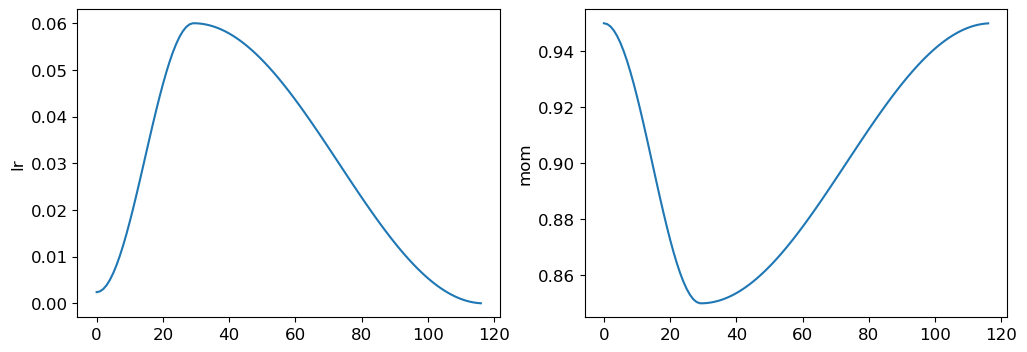

In [97]:
learn.recorder.plot_sched()

In [108]:
matplotlib.rcParams['image.cmap']='viridis'

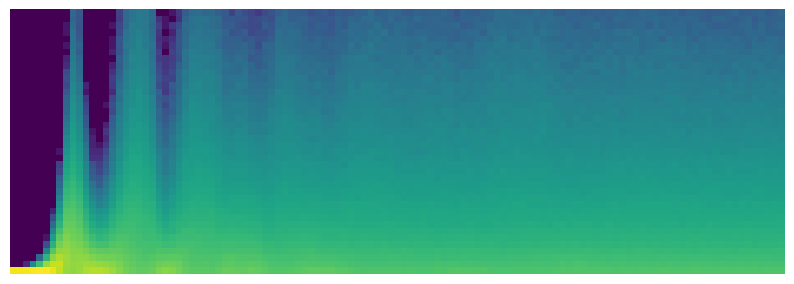

In [109]:
learn.activation_stats.color_dim(-2)

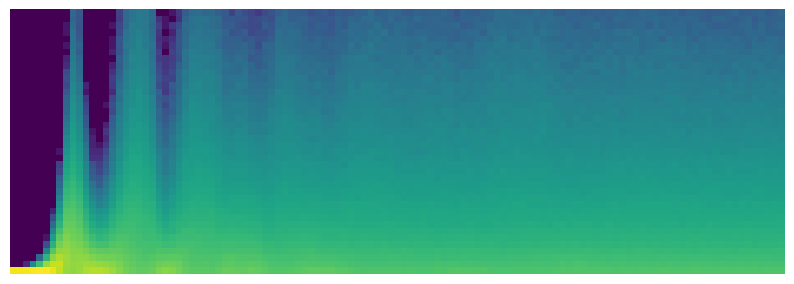

In [112]:
learn.activation_stats.color_dim(-2)

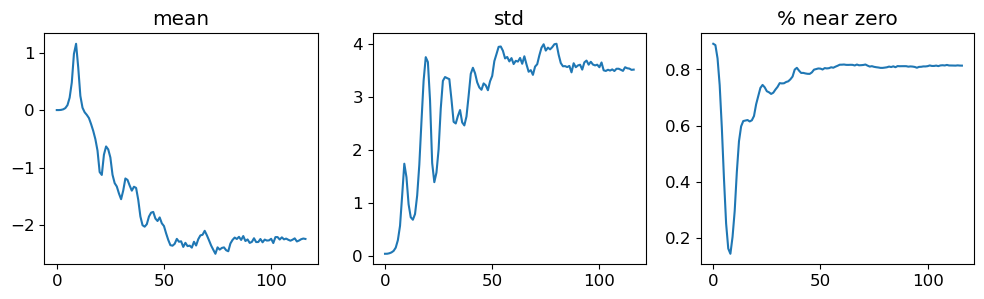

In [114]:
learn.activation_stats.plot_layer_stats(-2)

In [119]:
def conv(ni,nf,ks=3,act=true):
    layers=[nn.Conv2d(ni,nf,stride=2,kernel_size=ks,padding=ks//2)]
    if act: layers.append(nn.ReLU())
    layers.append(nn.BatchNorm2d(nf))
    return nn.Sequential(*layers)

In [120]:
learn=fit()

/opt/conda/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.129149,0.052833,0.986700,00:44


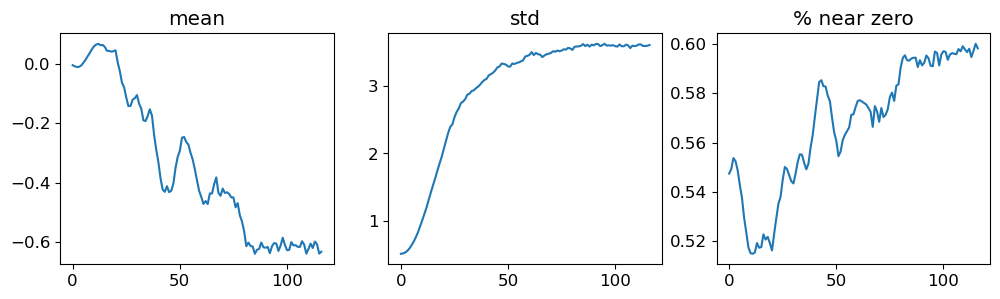

In [122]:
learn.activation_stats.plot_layer_stats(-4)

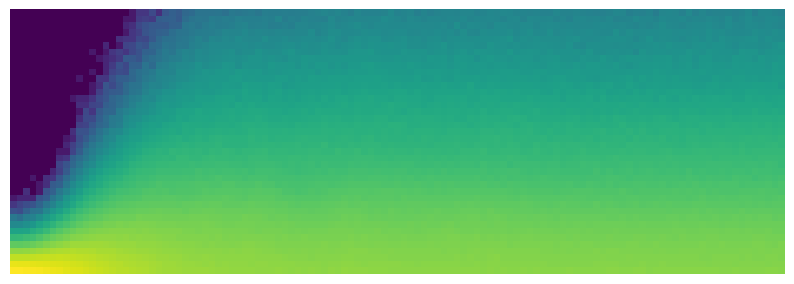

In [123]:
learn.activation_stats.color_dim(-4)

In [124]:
learn=fit(5,lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.185091,0.077559,0.976200,00:43
1,0.077376,0.088265,0.972500,00:44
2,0.050436,0.058172,0.982100,00:44
3,0.028249,0.029030,0.990300,00:44
4,0.014622,0.023168,0.992100,00:45
